# ForceSMIP Minimal Example: PLS Regression

By: Stephen Po-Chedley (based on [Po-Chedley et al. (2022)](https://www.pnas.org/doi/10.1073/pnas.2209431119))

Suggestions and Improvements Welcome!

The goal of this notebook is to demonstrate the use of PLS regression to estimate the forced and unforced components of global mean surface temperature variability and change. This notebook may be applied to other ForceSMIP variables, but some additional code may be requires. 

PLS (Partial Least Squares) Regression is a linear method that is comparable to EOF analysis in that it decomposes a matrix, **X**, into orthogonal modes. In PLS Regression, these modes are defined to explain the maximum variance of a predictand matrix, **Y**. In our case, we will use maps of annual average surface temperature anomaly (**X**) to predict the forced and unforced components of the global mean surface temperature anomaly (**Y**). These modes can be combined into forced and unforced coefficient maps ($\beta$) that can be convolved with an out-of-sample surface temperature anomaly map to predict the forced/unforced global temperature anomaly.

#### Outline:

* Description of the predictor, **X**, and predictand, **Y** matrices
* Notes on setup with conda
* Import of key packages
* Setting some user-specified options
* Define a function to read in the data, subset data, and compute annual average anomalies
* Read in the evaluation data (to ensure training/evaluation have the same missing data mask)
* Read in training / testing data
* Calculate the forced response for each model by taking the ensemble mean of all global mean time series
* Create standardized predictor and predictand matrices (to be used for training PLS Regression)
* Train PLS Regression Model
* See how well model works on models and ensemble members not used in training dataset
* Inspect PLS Modes and coefficients
* Apply PLS Regression Model to Evaluation data

### Description of Predictor and Predictand Matrices

Our general approach will be to relate a `lat` x `lon` map of anomalies to the forced and unforced global average anomaly value (the initial notebook is set to use surface temperature values, though you can change this – it may require some additional code to handle other variables). We essentially assume that the spatial pattern of anomalies gives us the information we need to estimate how much of the global average anomaly is forced-versus-unforced.

To populate our predictor matrix, **X**, we calculate the anomalies relative to some user-defined reference time period. Each grid cell (or "feature") is a column in our predictor matrix and each time step is a sample. The size of this matrix is the number of timesteps (n<sub>t</sub>) by the number of spatial points (n<sub>lat</sub> x n<sub>lon</sub>).

<p align="center">
  <img width=800 src="figs/anomaly_maps.png"/>
</p>

#### Building up samples

In order to build up samples to train our PLS Regression model, we add data from multiple model realizations to our predictor matrix (the user specifies the number of realizations). Our matrix then expands the number of rows (samples) so that it now has n<sub>t</sub> x n<sub>r</sub> rows where n<sub>r</sub> is the number of realizations. In the figure below, each blue block represents the data from one model realization. 

Since we do not want our PLS Regression Model to be overly specific to one climate model, we also add data from several user-specified climate models (different colors in the figure below). The models are all re-gridded to a common 2.5<sup>o</sup> x 2.5<sup>o</sup> grid (ForceSMIP data has already been re-mapped, so you do not need to worry about this step). Our matrix now has n<sub>t</sub> x n<sub>r</sub> x n<sub>m</sub> samples (where n<sub>m</sub> is the number of models).

#### The Predictand Matrix

We also build up a corresponding predictand matrix, **Y**. Each row in this matrix has two values: the global average forced and unforced climate anomaly. Each row in the **Y** matrix corresponds to a row in the **X** matrix, mapping the annual-mean anomaly maps to the global forced/unforced climate response. PLS Regression will be trained to determine the relationship between **X** and **Y**.

#### Normalization

Before calling our PLS Regression algorithm to relate **X** to **Y**, we a) remove columns with missing values in the **X** matrix and b) normalize both matrices so that each column has a mean of zero and a standard deviation of one. 

<p align="center">
  <img width=1000 src="figs/sampling.png" />
</p>

## Some setup notes

This setup assumes that you have anaconda installed. If you do not, you can install miniconda (from [here](https://docs.conda.io/en/main/miniconda.html)).

To create this environment we ran `conda create -n forcesmip -c conda-forge xcdat xesmf scikit-learn scipy eofs matplotlib cartopy nc-time-axis ipython ipykernel`

> Note: You may need to check your shell activate conda. To determine your shell, you can run `echo $SHELL`. You can then activate conda (based on your shell type, e.g., `conda init bash`). You may then need to subsequently re-source your shell (e.g., `source ~/.bashrc` for bash).

Activate your environment with: `conda activate forcesmip`

> Note: Alternatively, you can try `source activate forcesmip`

If you'd like to be able to use this environment with Jupyter, you need to install it with:

`python -m ipykernel install --user --name forcesmip --display-name forcesmip`

### Import packages

In [1]:
# I/O / data wrangling
import glob
import re
import numpy as np
import xcdat as xc

# runtime metrics
import time as clocktime

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# sklearn for pls regression
from sklearn.cross_decomposition import PLSRegression

# define a lambda function to perform natural sort
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split("(\d+)", s)]

### Define some static mappings for CMIP/ForceSMIP data

This is just some helper information to helps us search for data and reshape it. All ForceSMIP data is on a 2.5 x 2.5 degree lat/lon grid. 

In [2]:
cmipTable = {
    "pr": "Amon",
    "psl": "Amon",
    "tas": "Amon",
    "zmta": "Amon",
    "tos": "Omon",
    "siconc": "OImon",
    "monmaxpr": "Aday",
    "monmaxtasmax": "Aday",
    "monmintasmin": "Aday",
}
cmipVar = {
    "pr": "pr",
    "psl": "psl",
    "tas": "tas",
    "zmta": "ta",
    "tos": "tos",
    "siconc": "siconc",
    "monmaxpr": "pr",
    "monmaxtasmax": "tasmax",
    "monmintasmin": "tasmin",
}
evalPeriods = {
    "Tier1": ("1950-01-01", "2022-12-31"),
    "Tier2": ("1900-01-01", "2022-12-31"),
    "Tier3": ("1979-01-01", "2022-12-31"),
}
nlat = 72
nlon = 144

### Define user-specified parameters

In [3]:
# root_dir = "/net/krypton/climdyn_nobackup/FTP/ForceSMIP/"  # where is the data on the machine you're using (ETH)
root_dir = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/"  # where is the data on the machine you're using (NCAR)
n_members = 10  # number of members for training
ncvar = "tas"  # variable to be used: pr, psl, tas, zmta, tos, siconc, monmaxpr, monmaxtasmax, monmintasmin
n_pls_components = 5  # number of PLS modes to use
reference_period = ("1950-01-01", "1999-12-31") # climatological period (for anomaly calculations)
# choose models for training / testing
# choices include: 'CESM2', 'CanESM5', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-LR'
training_models = ["CESM2", "CanESM5", "MIROC6", "MPI-ESM1-2-LR"]
testing_models = ["MIROC-ES2L"]
# choose evaluation data
eval_tier = "Tier2"  # Tier1, Tier2, or Tier3
tv_time_period = evalPeriods[eval_tier]  # populates based on the evaluation data tier, but can be overwritten (with a tuple of date strings)

### Define a function to read in data

We're going to loop over many models and realizations for a) training, b) testing, and c) evaluation data. To make this more readable and to reduce repeating code, we are going to define a function to do this operation.

In [4]:
def load_realization(fn, vid, time_period, reference_period):
    """
    load_realization(fn, vid, time_period, reference_period)
    
    Function loads in data for a given file, fn, and variable, vid. It
    selects data for a given time_period and calculates the annual anomalies
    relative to a user-defined reference_period. The function returns the 3D
    anomaly map, and the global mean time series. 
    
    Inputs:
    -------
    fn (str) : filename
    vid (str) : variable id
    time_period (tuple(str, str)) : tuple of the start and end of the time period
                                    e.g., ("1900-01-01", "1949-12-31")
    reference_period (tuple(str, str)) : tuple of the start and end of the reference period
                                         used to calculate anomalies e.g., ("1900-01-01", "1949-12-31")
                                         
    Returns:
    --------
    ts_3d (xr.DataArray) : annual average anomaly values [time, lat, lon]
    ts_gm (xr.DataArray) : annual average, global mean anomaly values
    """
    # open dataset
    ds = xc.open_dataset(fn)
    # if specified, subset training/validation data to specific period
    if tv_time_period is not None:
        ds = ds.sel(time=slice(time_period[0], time_period[1]))
    # get departures
    ds = ds.temporal.departures(vid, freq="month", reference_period=reference_period)
    # take annual average
    # Note: xcdat takes the annual average ignoring NaN values
    ds = ds.temporal.group_average(vid, freq="year", weighted=False)
    ts_3d = ds[vid]
    # take spatial average
    ds = ds.spatial.average(vid)
    ts_gm = ds[vid]
    # clean up 
    ds.close()
    # return values
    return ts_3d, ts_gm

### Read in evaluation data

We start with the evaluation data, because this data includes observations...and missing data. We will load the evaluation data and create a missing data mask, which we will apply to the training/testing data as well. That way the training and evaluation data will be consistent. We store data in a nested dictionary (with the model names as keys). 

*Important note*: we use annual averages in this notebook (which hides missing monthly values). A better method would be to mask at the monthly timescale. 

In [5]:
# first we search for the evaluation data
epath = "/".join([root_dir, "Evaluation-" + eval_tier, cmipTable[ncvar], ncvar])
efiles = glob.glob(epath + "/*.nc")
efiles = sorted(efiles, key=natsort)

# initialize dictionary to store data
evaluation_annual_anomaly_maps = {}
vid = cmipVar[ncvar]
mean_map_list = []

# loop over evaluation files
for im, fn in enumerate(efiles):
    # get evaluation identifier
    model = fn.split("/")[-1].split("_")[2].split(".")[0]
    # print progress
    print(str(im + 1) + " / " + str(len(efiles)) + ": " + model)
    # read in data for realization
    ts_3d, ts_gm = load_realization(fn, vid, tv_time_period, reference_period)
    # store anomaly map
    evaluation_annual_anomaly_maps[model] = ts_3d
    # store longterm mean (for mask)
    mean_map_list.append(ts_3d.mean(dim='time', skipna=False))
    
# create mask for missing data
mean_map_list = np.array(mean_map_list)
missing_data_mask = np.mean(mean_map_list, axis=0)
missing_data_mask = np.where(np.isnan(missing_data_mask), np.nan, 1)

1 / 10: 2A
2 / 10: 2B
3 / 10: 2C
4 / 10: 2D
5 / 10: 2E
6 / 10: 2F
7 / 10: 2G
8 / 10: 2H
9 / 10: 2I
10 / 10: 2J


### Loop over models and retrieve global mean time series and anomaly maps

We store data in a nested dictionary (with the model and member names as keys). This data will be used for training our PLS regression model (and then testing how well it works on data not included in training).

We store `n_member` anomaly maps for training and all of the global mean time series. Individual model ensemble average, global mean time series are considered the model forced response. The difference between an individual global mean time series and the forced response time series is the unforced global mean time series. 

In [6]:
# initialize dictionary to store data
global_mean_timeseries = {}
annual_anomaly_maps = {}
vid = cmipVar[ncvar]
# loop over models
models = training_models + testing_models
for im, model in enumerate(models):
    # start timer
    stime = clocktime.time()
    # initialize nested dictionary for model data
    global_mean_timeseries[model] = {}
    annual_anomaly_maps[model] = {}
    # get model files
    mpath = "/".join([root_dir, "Training", cmipTable[ncvar], ncvar, model])
    mfiles = glob.glob(mpath + "/*.nc")
    # parse file names to get list of model members
    # CESM2 has a non-CMIP naming convention
    if model == "CESM2":
        members = [p.split("ssp370_")[-1].split(".1880")[0] for p in mfiles]
    else:
        members = [p.split("_")[-1].split(".")[0] for p in mfiles]
    members = sorted(members, key=natsort)
    # print progress
    print(str(im + 1) + " / " + str(len(models)) + ": " + model + " (" + str(len(members)) + " members)")
    # loop over model members
    for imm, member in enumerate(members):
        # define member filename
        fn = glob.glob(mpath + "/*_" + member + ".*.nc")
        # make sure filename is unique
        if len(fn) != 1:
            raise ValueError("Unexpected number of model members")
        else:
            fn = fn[0]
        # load data for realization
        ts_3d, ts_gm = load_realization(fn, vid, tv_time_period, reference_period)
        # store first N+1 anomaly maps from training models [we keep one extra to inspect skill]
        # also store all data for the validation models
        if ((imm <= n_members) & (model in training_models)) | (model in testing_models):
            # mask missing data
            aam = ts_3d * np.tile(
                np.expand_dims(missing_data_mask, axis=0), (ts_3d.shape[0], 1, 1)
            )
            # store masked data in array
            annual_anomaly_maps[model][member] = aam
        # save global mean time series for all model members
        global_mean_timeseries[model][member] = ts_gm
        # update progress
        print(".", end="")
    # print time elapse for model
    etime = clocktime.time()
    print()
    print("Time elapsed: " + str(etime - stime) + " seconds")
    print()

1 / 5: CESM2 (50 members)
..................................................
Time elapsed: 99.08836698532104 seconds

2 / 5: CanESM5 (25 members)
.........................
Time elapsed: 51.322659969329834 seconds

3 / 5: MIROC6 (50 members)
..................................................
Time elapsed: 110.3073832988739 seconds

4 / 5: MPI-ESM1-2-LR (30 members)
..............................
Time elapsed: 60.02335166931152 seconds

5 / 5: MIROC-ES2L (30 members)
..............................
Time elapsed: 61.237512826919556 seconds



### Calculate the global/ensemble mean forced response 

Here we gather all of the data for a given model ensemble and then compute the ensemble mean time series (our estimate of the forced response).

In [7]:
# initialize dictionary to hold forced response time series
import xarray as xr
forced_global_mean_timeseries = {}
# loop over models
for model in models:
    # get model members
    members = global_mean_timeseries[model].keys()
    # initialize list to hold time series for all members
    mgmts = []
    # loop over members
    for member in members:
        # add member time series to list
        ts = global_mean_timeseries[model][member]
        mgmts.append(ts)
    # add ensemble mean time series to dictionary
    da = xr.concat(mgmts, dim='ensemble')
    forced_global_mean_timeseries[model] = da.mean(dim='ensemble')

### Show forced and (example) unforced time series

Just plot the data as a sanity check. We show the first unforced time series as an example.

Text(0, 0.5, 'Unforced GMST')

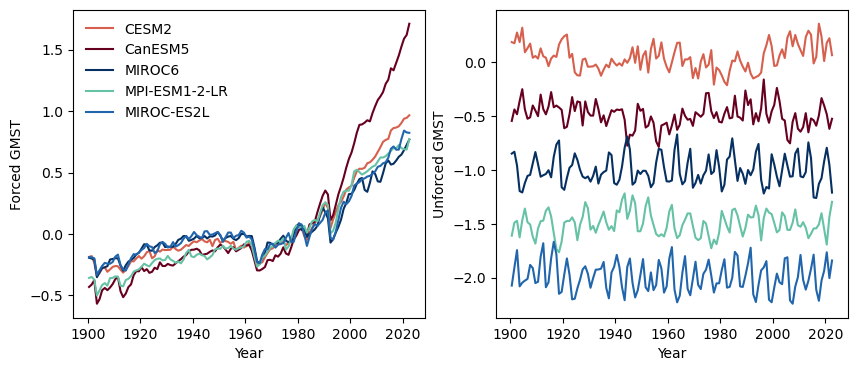

In [8]:
# define some model colors (loosely sorted based on ECS, blue to red)
modelColors = {
    "CESM2": "#d6604d",
    "CanESM5": "#67001f",
    "MIROC-ES2L": "#2166ac",
    "MIROC6": "#053061",
    "MPI-ESM1-2-LR": "#66c2a5",
}
# create figure
plt.figure(figsize=(10, 4))
# loop over models
for im, model in enumerate(models):
    # get and plot forced time series
    tsf = forced_global_mean_timeseries[model]
    time = [t.year + 0.5 for t in tsf.time.values]
    plt.subplot(1, 2, 1)
    plt.plot(time, tsf, color=modelColors[model], label=model)
    # get and plot unforced time series (for one member)
    plt.subplot(1, 2, 2)
    member1 = list(global_mean_timeseries[model].keys())[0]
    tsu = global_mean_timeseries[model][member1] - tsf
    plt.plot(time, tsu - im * 0.5, color=modelColors[model], label=model)
# legend / labels
plt.subplot(1, 2, 1)
plt.legend(loc="upper left", frameon=False)
plt.xlabel("Year")
plt.ylabel("Forced GMST")
plt.subplot(1, 2, 2)
plt.xlabel("Year")
plt.ylabel("Unforced GMST")

### Create predictor / predictand matrices

The predictor matrix, **X**, is of the form `[nsamples, nfeatures]` where the number of samples is the product of the number of climate models used in the training dataset, the number of ensemble members considered, and the length of the time series. The number of features is the number of spatial points (`lat` x `lon`), 10368. The predictand matrix, Y, is of the form `[nsamples, 2]`. The number of the samples is the same as the predictor matrix. There are two columns in the **Y** matrix because we are predicting the forced and unforced component of the time series. 

In [9]:
# initialize X/Y matrices
n_models = len(training_models)
n_timesteps = len(global_mean_timeseries[model][member])
nsamples = n_models * n_members * n_timesteps
nfeatures = nlat * nlon
X = np.zeros((nsamples, nfeatures)) * np.nan
Y = np.zeros((nsamples, 2)) * np.nan
validation_members = {}

# populate matrices
imember = 0  # counting variable
# loop over models
for model in training_models:
    # get members for training and validation
    members = list(annual_anomaly_maps[model].keys())
    # we will consider the last member as the validation member
    validation_members[model] = members[-1]
    # retrieve forced time series (calculated above)
    gmf = np.array(forced_global_mean_timeseries[model])
    # loop over first n_members
    for member in members[0:n_members]:
        # retrieve full [time, lat, lon] time series for X matrix
        # note that data is transformed to [time, space]
        xmaps = np.array(annual_anomaly_maps[model][member])
        xmaps = np.reshape(xmaps, (n_timesteps, -1))
        # add full time series to X matrix
        X[imember * n_timesteps : imember * n_timesteps + n_timesteps, :] = xmaps
        # compute unforced time series
        gmu = np.array(global_mean_timeseries[model][member]) - gmf
        # add forced and unforced global mean time series to Y matrix
        Y[imember * n_timesteps : imember * n_timesteps + n_timesteps, 0] = gmu
        Y[imember * n_timesteps : imember * n_timesteps + n_timesteps, 1] = gmf
        imember += 1  # increment counting variable

# handle missing data
XY_DATA = np.where(~np.isnan(X[0]))[0]  # indices where valid data exists
X = X[:, XY_DATA]

### Normalize matrices

It is standard practice to normalize the predictor / predictand matrix so that the mean is zero and the standard deviation is one (at all spatial points). 

In [10]:
# compute X/Y mean / standard deviation
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
Y_mean = np.mean(Y, axis=0)
Y_std = np.std(Y, axis=0)
# normalize
X = (X - X_mean) / X_std
Y = (Y - Y_mean) / Y_std

### Initialize and fit PLS Regression model

In [11]:
pls2 = PLSRegression(n_components=n_pls_components)
pls2.fit(X, Y)

PLSRegression(n_components=5)

### Predict forced / unforced global mean time series for out-of-sample ensemble members

Simply loop over the training models and use the PLS Regression model to predict the forced / unforced component of the time series for out of sample model members.

In [12]:
# loop over models
predicted_global_mean_timeseries = {}
for model in training_models:
    predicted_global_mean_timeseries[model] = {}
    # get validation members
    member = validation_members[model]
    # loop over members and gather all predictor maps
    XV = np.zeros((n_timesteps, nfeatures)) * np.nan
    xmaps = np.array(annual_anomaly_maps[model][member])
    XV = np.reshape(xmaps, (n_timesteps, -1))
    # remove missing data
    XV = XV[:, XY_DATA]
    # normalize
    XV = (XV - X_mean) / X_std
    # apply PLS regression to predict forced/unforced components
    YP = pls2.predict(XV)
    # un-normalize predictand time series
    YP = YP * Y_std + Y_mean
    predicted_global_mean_timeseries[model][member] = YP

### Plot predicted time series for the first validation member

Plot the predicted-versus-actual forced/unforced components of the series. Note that the plots are for models used in training, but the specific realizations were not included in the training.

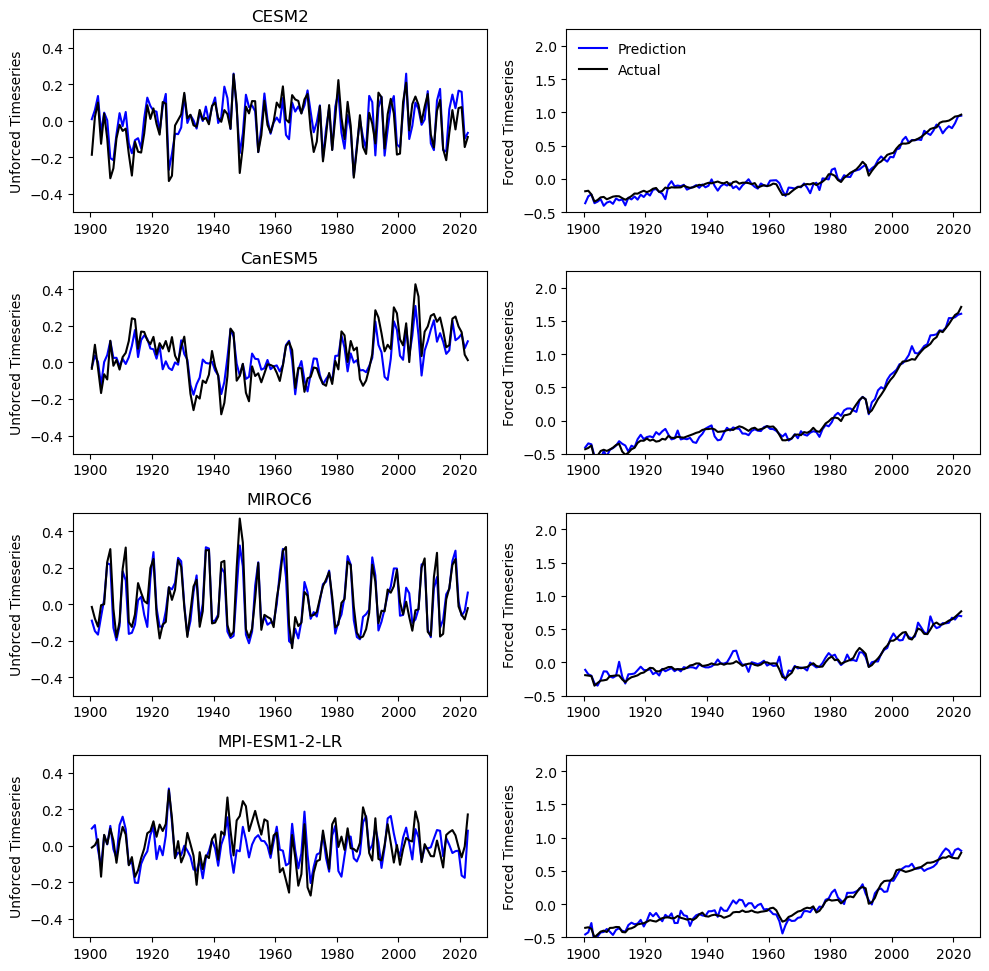

In [13]:
# create figure
plt.figure(figsize=(10, 12))
# loop over training models
for im, model in enumerate(training_models):
    # get evaluation member
    member = validation_members[model]
    # get predicted time series
    YP = predicted_global_mean_timeseries[model][member]
    # get "actual" forced/unforced timeseries
    gmf = forced_global_mean_timeseries[model]
    gmu = global_mean_timeseries[model][member] - gmf
    # plot unforced time series
    plt.subplot(len(models), 2, im * 2 + 1)
    plt.plot(time, YP[:, 0], "b", label="Prediction")
    plt.plot(time, gmu, "k", label="Actual")
    plt.title(model)
    plt.ylim(-0.5, 0.5)
    plt.ylabel("Unforced Timeseries")
    # plot forced time series
    plt.subplot(len(models), 2, im * 2 + 2)
    plt.plot(time, YP[:, 1], "b", label="Prediction")
    plt.plot(time, gmf, "k", label="Actual")
    plt.ylim(-0.5, 2.25)
    plt.ylabel("Forced Timeseries")
    # add legend to upper right plot
    if im == 0:
        plt.legend(loc="upper left", frameon=False)
plt.tight_layout(w_pad=3)

### Predict forced / unforced global mean time series for out-of-sample ensemble *models*

Do the same thing, but for models that were not included in the training dataset.

In [14]:
# loop over validation models
for model in testing_models:
    # create empty nested dictionary
    predicted_global_mean_timeseries[model] = {}
    # get members
    members = list(annual_anomaly_maps[model].keys())
    validation_members[model] = members[0]
    # loop over members and gather all predictor maps
    XV = np.zeros((n_timesteps * len(members), nfeatures)) * np.nan
    for im, member in enumerate(members):
        xmaps = np.array(annual_anomaly_maps[model][member])
        xv = np.reshape(xmaps, (n_timesteps, -1))
        XV[im * n_timesteps : im * n_timesteps + n_timesteps, :] = xv
    # remove missing data
    XV = XV[:, XY_DATA]
    # normalize
    XV = (XV - X_mean) / X_std
    # apply PLS regression to predict forced/unforced components (for all members at once)
    YP = pls2.predict(XV)
    # un-normalize predictand time series
    YP = YP * Y_std + Y_mean
    # extract data for each member and store in dictionary
    for im, member in enumerate(members):
        predicted_global_mean_timeseries[model][member] = YP[im * n_timesteps : im * n_timesteps + n_timesteps, :]

### Plot predicted time series for the out-of-sample *model*

This is the same thing as before, except that this model was *not* included in the training dataset at all.

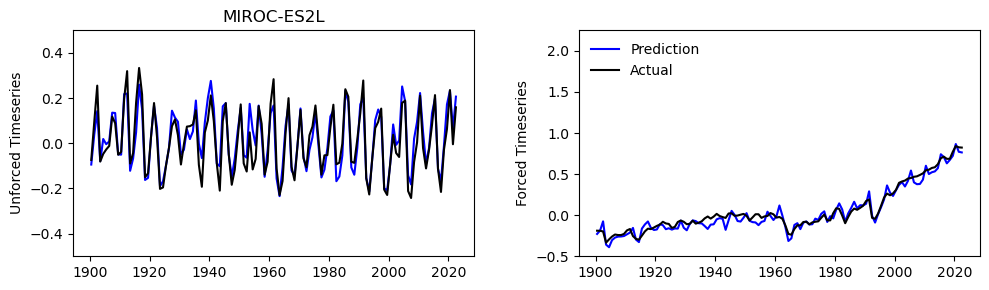

In [15]:
plt.figure(figsize=(10, len(testing_models) * 3))
im = 0
for model in testing_models:
    member = validation_members[model]
    # get predicted time series
    YP = predicted_global_mean_timeseries[model][member]
    # get "actual" forced/unforced timeseries
    gmf = forced_global_mean_timeseries[model]
    gmu = global_mean_timeseries[model][member] - gmf
    # plot
    plt.subplot(len(testing_models), 2, im * 2 + 1)
    plt.plot(time, YP[:, 0], "b", label="Prediction")
    plt.plot(time, gmu, "k", label="Actual")
    plt.title(model)
    plt.ylim(-0.5, 0.5)
    plt.ylabel("Unforced Timeseries")
    plt.subplot(len(testing_models), 2, im * 2 + 2)
    plt.plot(time, YP[:, 1], "b", label="Prediction")
    plt.plot(time, gmf, "k", label="Actual")
    plt.ylim(-0.5, 2.25)
    plt.ylabel("Forced Timeseries")
    if im == 0:
        plt.legend(loc="upper left", frameon=False)
plt.tight_layout(w_pad=3)

### Compute unforced trends (predicted and actual)

We will look at the unforced trends over the satellite-era (1979 - 2022)

In [16]:
# create empty lists for predicted/actual trends
trends_predicted = []
trends_actual = []
# get indices for desired time range
time = np.array(time)
ITIME = np.where((time > 1979) & (time < 2023))[0]
# get first validation model
model = testing_models[0]
members  = global_mean_timeseries[model].keys()
for member in members:
    # get unforced time series
    tsf = forced_global_mean_timeseries[model]
    tsu = global_mean_timeseries[model][member] - tsf
    # get predicted unforced time series
    YPU = predicted_global_mean_timeseries[model][member][:, 0]
    # compute linear trends
    mu, b = np.polyfit(time[ITIME], tsu[ITIME], 1)
    mpu, b = np.polyfit(time[ITIME], YPU[ITIME], 1)
    # store trends (in units of per decade)
    trends_predicted.append(mpu*10)
    trends_actual.append(mu*10)

### Plot predicted-versus-actual unforced trends

Text(-0.04, -0.035, '1 : 1')

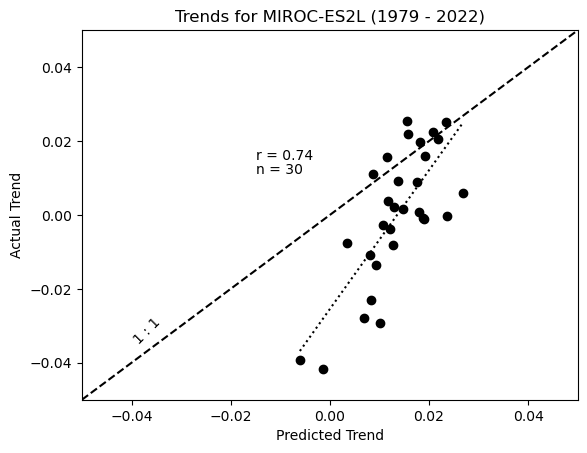

In [17]:
# plot predicted-versus-actual trends
plt.scatter(trends_predicted, trends_actual, color='k')
# best fit line
plt.plot(np.unique(trends_predicted), np.poly1d(np.polyfit(trends_predicted, trends_actual, 1))(np.unique(trends_predicted)), 'k:')
# compute and label correlation and ensemble size
r = np.corrcoef(trends_predicted, trends_actual)[0, 1]
plt.text(-0.015, 0.015, 'r = ' + str(np.round(r, 2)), fontsize=10)
plt.text(-0.015, 0.011, 'n = ' + str(len(members)), fontsize=10)
# axis labels
plt.xlabel('Predicted Trend')
plt.ylabel('Actual Trend')
plt.title('Trends for ' + model + ' (1979 - 2022)')
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.plot([-0.05, 0.05], [-0.05, 0.05], 'k--')
plt.text(-0.04, -0.035, '1 : 1', color='k', rotation=45)

### Compute and plot some simple skill metrics

Compute the temporal correlation coefficient and the RMSE value for each of the validation members. We denote the validation models with an asterisk.

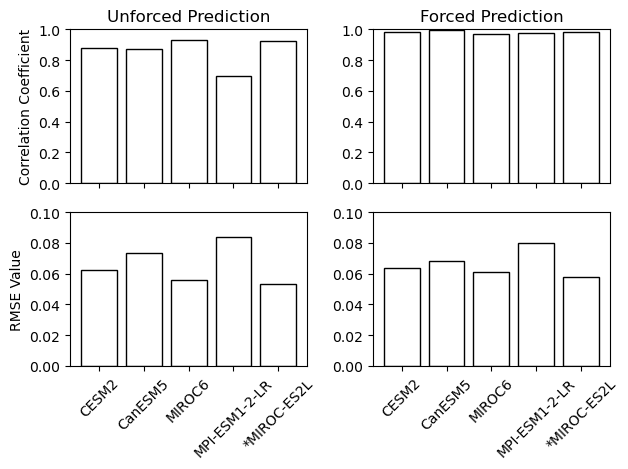

In [18]:
# initialize dictionaries to hold skill metrics
r_values = {}
rmse_values = {}
# loop over models
for im, model in enumerate(models):
    # get validation member
    member = validation_members[model]
    # get predicted time series
    YP = predicted_global_mean_timeseries[model][member]
    pgmu = YP[:, 0]
    pgmf = YP[:, 1]
    # get "actual" forced/unforced timeseries
    gmf = forced_global_mean_timeseries[model]
    gmu = global_mean_timeseries[model][member] - gmf
    # compute /store correlation
    rf = np.corrcoef(gmf, pgmf)[0, 1]
    ru = np.corrcoef(gmu, pgmu)[0, 1]
    r_values[model] = [ru, rf]
    # compute /store rmse
    rmsef = np.sqrt(np.mean((pgmf - gmf) ** 2))
    rmseu = np.sqrt(np.mean((pgmu - gmu) ** 2))
    rmse_values[model] = [rmseu, rmsef]

# create labels for plot
# if model is a validation model add an asterisk
mlabels = []
for model in models:
    if model in testing_models:
        mlabels.append("*" + model)
    else:
        mlabels.append(model)

# plot histogram: r-values (top row)
plt.subplot(2, 2, 1)
plt.bar(np.arange(5), [r_values[m][0] for m in models], facecolor="w", edgecolor="k")
plt.xticks(np.arange(5), labels=["" for m in models], rotation=45)
plt.ylim(0, 1)
plt.title("Unforced Prediction")
plt.ylabel("Correlation Coefficient")

plt.subplot(2, 2, 2)
plt.bar(np.arange(5), [r_values[m][1] for m in models], facecolor="w", edgecolor="k")
plt.xticks(np.arange(5), labels=["" for m in models], rotation=45)
plt.ylim(0, 1)
plt.title("Forced Prediction")

# plot histogram: rmse values (bottom row)
plt.subplot(2, 2, 3)
plt.bar(np.arange(5), [rmse_values[m][0] for m in models], facecolor="w", edgecolor="k")
plt.xticks(np.arange(5), labels=mlabels, rotation=45)
plt.ylim(0, 0.1)
plt.ylabel("RMSE Value")

plt.subplot(2, 2, 4)
plt.bar(np.arange(5), [rmse_values[m][1] for m in models], facecolor="w", edgecolor="k")
plt.xticks(np.arange(5), labels=mlabels, rotation=45)
plt.ylim(0, 0.1)

plt.tight_layout()

### Examine the PLS modes

Recall that PLS is similar to principal component analysis in that it is composed of several modes. Here we show the modes that were calculated for this PLS Regression model. 

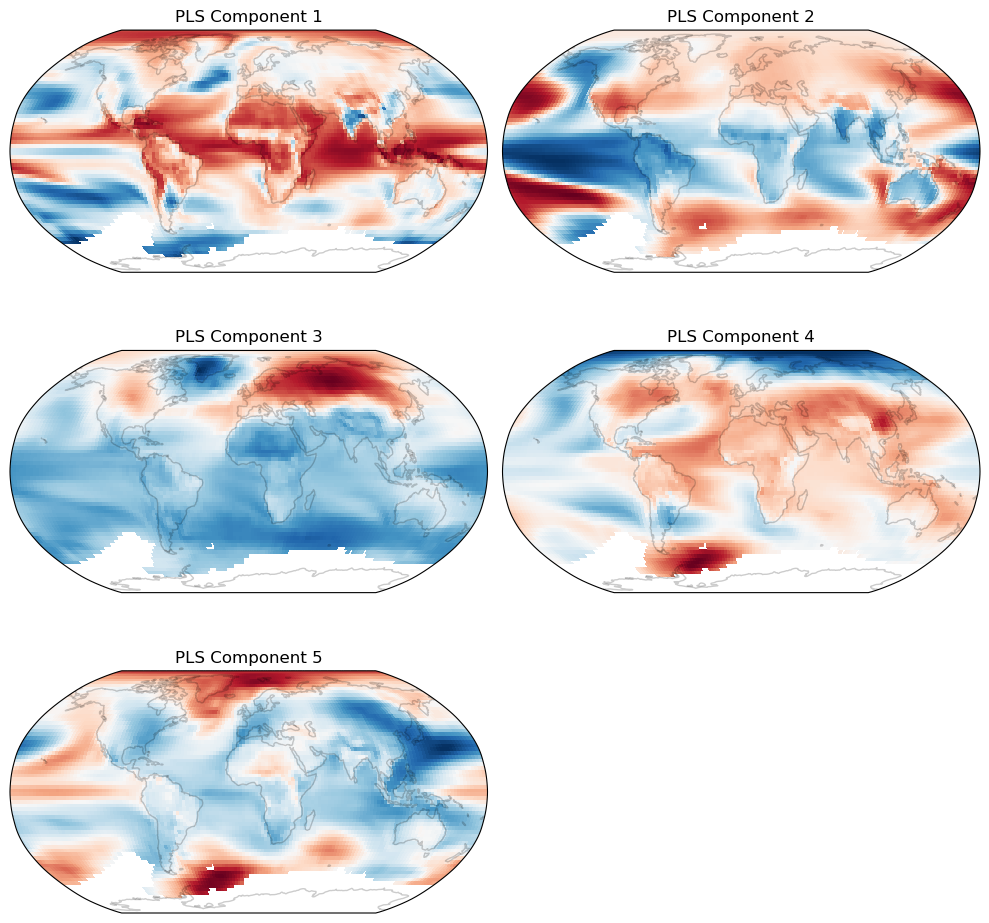

In [19]:
plt.figure(figsize=(10, 10))
# get dims for plotting (from first model/member metadata)
model1 = models[0]
member1 = list(annual_anomaly_maps[model1].keys())[0]
lat = annual_anomaly_maps[model1][member1].lat
lon = annual_anomaly_maps[model1][member1].lon
for i in range(5):
    plt.subplot(3, 2, i + 1, projection=ccrs.Robinson())
    # create matrix to hold coefficient maps
    xloading = np.zeros(nlat * nlon) * np.nan
    # place coefficient in matrix (where non-NaN grid cells exist)
    xloading[XY_DATA] = pls2.x_loadings_[:, i]
    # re-shape to lat/lon array
    xloading = np.reshape(xloading, (nlat, nlon))
    # plot
    plt.pcolor(lon, lat, xloading, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    plt.title("PLS Component " + str(i + 1))
plt.tight_layout()

### Examine Coefficient (aka "Fingerprint") maps

PLS produces coefficient (i.e., fingerprint) maps `[lat, lon]`. These maps are dotted with a full field `[time, lat, lon]` to produce time series of the forced and unforced global mean time series. We show the fingerprint maps here.

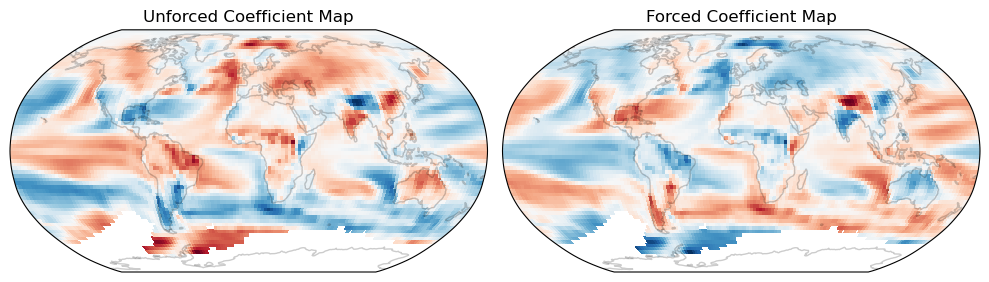

In [20]:
# create matrix to hold coefficient maps
beta_unforced = np.zeros(nlat * nlon) * np.nan
beta_forced = np.zeros(nlat * nlon) * np.nan
# place coefficient in matrix (where non-NaN grid cells exist)
beta_unforced[XY_DATA] = pls2.coef_[0, :]
beta_forced[XY_DATA] = pls2.coef_[1, :]
# reshape to lat x lon matrix
beta_unforced = np.reshape(beta_unforced, (nlat, nlon))
beta_forced = np.reshape(beta_forced, (nlat, nlon))

# plot maps
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1, projection=ccrs.Robinson())
plt.pcolor(lon, lat, beta_unforced, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)
plt.gca().set_global()
plt.gca().coastlines(alpha=0.2)
plt.title("Unforced Coefficient Map")
plt.subplot(1, 2, 2, projection=ccrs.Robinson())
plt.pcolor(lon, lat, beta_forced, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)
plt.gca().set_global()
plt.gca().coastlines(alpha=0.2)
plt.title("Forced Coefficient Map")
plt.tight_layout()

### Apply PLS Regression to Evaluation Data

In [21]:
evaluation_models = list(evaluation_annual_anomaly_maps.keys())
# loop over models
for model in evaluation_models:
    # get predictor matrix
    xmaps = np.array(evaluation_annual_anomaly_maps[model])
    XV = np.reshape(xmaps, (n_timesteps, -1))
    # remove missing data
    XV = XV[:, XY_DATA]
    # normalize
    XV = (XV - X_mean) / X_std
    # apply PLS regression to predict forced/unforced components
    YP = pls2.predict(XV)
    # un-normalize predictand time series
    YP = YP * Y_std + Y_mean
    predicted_global_mean_timeseries[model] = YP

### Plot predictions for evaluation time series

Now we apply our PLS regression model to evaluation data that was not included in training (and we do not know the "true" answer).

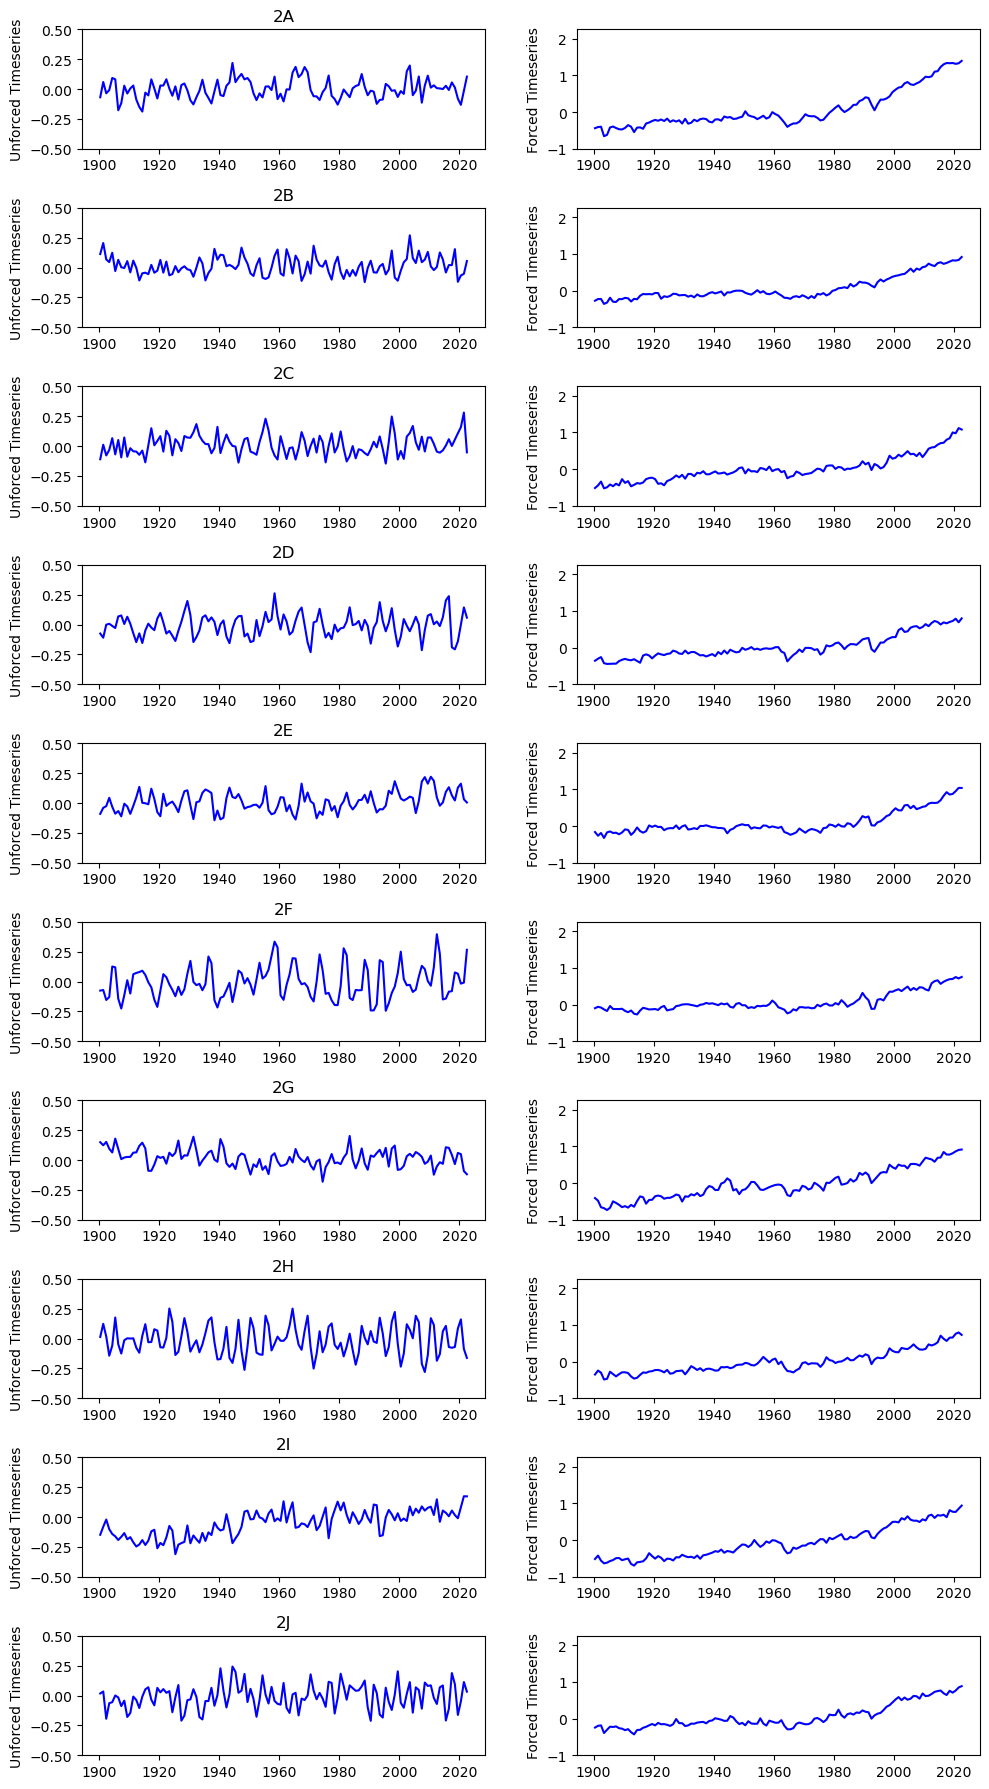

In [22]:
plt.figure(figsize=(10, 18))
for im, model in enumerate(evaluation_models):
    # get predicted time series
    YP = predicted_global_mean_timeseries[model]
    # plot unforced time series
    plt.subplot(len(evaluation_models), 2, im * 2 + 1)
    plt.plot(time, YP[:, 0], "b", label="Prediction")
    plt.title(model)
    plt.ylim(-0.5, 0.5)
    plt.ylabel("Unforced Timeseries")
    # plot forced time series
    plt.subplot(len(evaluation_models), 2, im * 2 + 2)
    plt.plot(time, YP[:, 1], "b", label="Prediction")
    plt.ylim(-1, 2.25)
    plt.ylabel("Forced Timeseries")
plt.tight_layout(w_pad=3)

### Discussion Questions

* Why do you think the coefficient maps look the way they do?
* We masked out grid cells that had any missing data. Can you think of a better way to handle missing data?
* The number of PLS modes (5 used here) is set by the user and is known as a hyperparameter. How could we decide and justify the number of modes used?
* The ForceSMIP protocol asks for spatially resolved predictions of the forced response (e.g., [`time`, `lat`, `lon`]) on *monthly* timescales. How could you extend this notebook to go from annual, global mean predictions to monthly, spatially resolved predictions?
* Do you think this approach would work well for other variables of interest?